In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ink_detection_utils import load_dataset
from ink_detection_utils import get_crop_numer_list
from ink_detection_utils import stitch_crops

from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [20]:
VESUVIUS_DATA_PATH = '../../Datasets/vesuvius-challenge-ink-detection/'

layer_depth = 32
crop_size = 256

In [6]:
train_data = load_dataset(VESUVIUS_DATA_PATH, dataset = 'train')

Fragment: 1 Loaded: crop_7.png
Fragment: 1 Loaded: crop_8.png
Fragment: 1 Loaded: crop_9.png
Fragment: 1 Loaded: crop_10.png
Fragment: 1 Loaded: crop_11.png
Fragment: 1 Loaded: crop_12.png
Fragment: 1 Loaded: crop_13.png
Fragment: 1 Loaded: crop_19.png
Fragment: 1 Loaded: crop_20.png
Fragment: 1 Loaded: crop_21.png
Fragment: 1 Loaded: crop_22.png
Fragment: 1 Loaded: crop_23.png
Fragment: 1 Loaded: crop_24.png
Fragment: 1 Loaded: crop_25.png
Fragment: 1 Loaded: crop_26.png
Fragment: 1 Loaded: crop_27.png
Fragment: 1 Loaded: crop_32.png
Fragment: 1 Loaded: crop_33.png
Fragment: 1 Loaded: crop_34.png
Fragment: 1 Loaded: crop_35.png
Fragment: 1 Loaded: crop_36.png
Fragment: 1 Loaded: crop_37.png
Fragment: 1 Loaded: crop_38.png
Fragment: 1 Loaded: crop_39.png
Fragment: 1 Loaded: crop_40.png
Fragment: 1 Loaded: crop_41.png
Fragment: 1 Loaded: crop_45.png
Fragment: 1 Loaded: crop_46.png
Fragment: 1 Loaded: crop_47.png
Fragment: 1 Loaded: crop_48.png
Fragment: 1 Loaded: crop_49.png
Fragment: 1

In [7]:
train_dataset = train_data

In [8]:
train_dataset[0][0].shape

(167, 65, 256, 256, 3)

In [9]:
train_dataset[0][1].shape

(167, 256, 256, 3)

In [10]:
frag_1_volumes = train_dataset[0][0]
frag_1_labels = train_dataset[0][1]

frag_1_volumes = frag_1_volumes[:,:,:,:,0]
frag_1_labels = frag_1_labels[:,:,:,0]/255

In [11]:
frag_1_volumes.shape

(167, 65, 256, 256)

In [12]:
frag_1_labels.shape

(167, 256, 256)

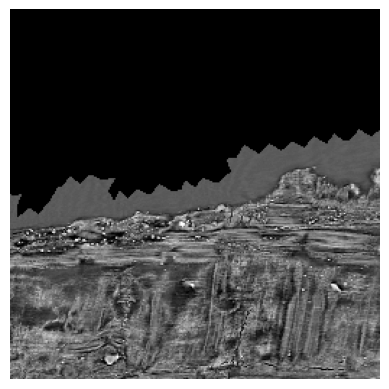

In [13]:
# Display the grayscale image
plt.imshow(frag_1_volumes[0][0], cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

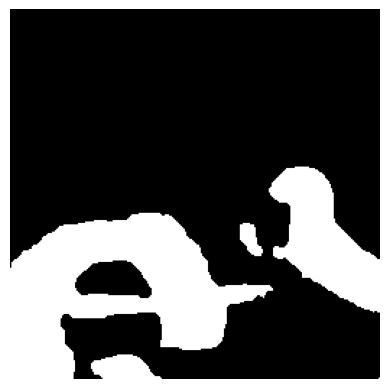

In [14]:
# Display the grayscale image
plt.imshow(frag_1_labels[0], cmap="gray")
plt.axis("off")
plt.show()

In [15]:
frag_1_volumes[0][0].shape

(256, 256)

In [16]:
frag_1_labels[0].shape

(256, 256)

In [17]:
frag_1_labels[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.]])

In [21]:
frag_1_volumes = frag_1_volumes.reshape(frag_1_volumes.shape[0],frag_1_volumes.shape[1],crop_size,crop_size)
frag_1_labels = frag_1_labels.reshape(frag_1_volumes.shape[0],1,crop_size,crop_size)

In [22]:
#Do this processing for all fragments

for i in range(len(train_dataset)):
    train_dataset[i][0] = train_dataset[i][0][:,:,:,:,0]
    train_dataset[i][1] = train_dataset[i][1][:,:,:,0]/255

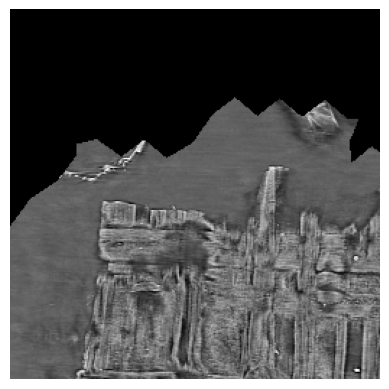

In [23]:
# Display the grayscale image
plt.imshow(train_dataset[1][0][0][0], cmap="gray") # [fragment][train][layer][image]
plt.axis("off")
plt.show()

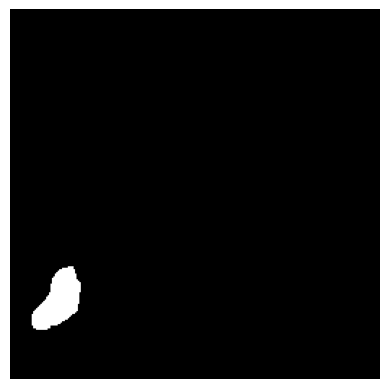

In [24]:
# Display the grayscale image
plt.imshow(train_dataset[1][1][0], cmap="gray") # [fragment][label][image]
plt.axis("off")
plt.show()

In [25]:
train_dataset[1][0][0][0].shape

(256, 256)

In [26]:
train_dataset[1][1][0].shape

(256, 256)

In [27]:
#Reshape dataset
for i in range(len(train_dataset)):
    train_dataset[i][0] = train_dataset[i][0].reshape(train_dataset[i][0].shape[0],train_dataset[i][0].shape[1],crop_size,crop_size)
    train_dataset[i][1] = train_dataset[i][1].reshape(train_dataset[i][1].shape[0],1,crop_size,crop_size)

In [28]:
train_dataset[1][0][0][0].shape

(256, 256)

In [29]:
train_dataset[1][1][0].shape

(1, 256, 256)

In [30]:
# Concatenate the arrays along the first dimension
volume_data = np.concatenate([arr[0] for arr in train_dataset], axis=0)
label_data = np.concatenate([arr[1] for arr in train_dataset], axis=0)

In [31]:
volume_data = volume_data[:,18:50,:,:,]
volume_data.shape

(896, 32, 256, 256)

In [32]:
label_data.shape

(896, 1, 256, 256)

In [35]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_val, Y_train, Y_val = train_test_split(volume_data, label_data, test_size=0.05)

In [36]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (851, 32, 256, 256)
Train labels shape: (851, 1, 256, 256)
Validation images shape: (45, 32, 256, 256)
Validation labels shape: (45, 1, 256, 256)


In [37]:
#UNet Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as func

from torch.utils.data import DataLoader, Dataset

In [38]:
torch.cuda.empty_cache()

In [39]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [40]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [41]:
train_dataset = CharacterDataset(X_train, Y_train)
val_dataset = CharacterDataset(X_val, Y_val)

In [42]:
#Simple UNet Model without skip connections. Works with 512x512 image size

class UNetWithoutSkipConnections(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob):
        super(UNetWithoutSkipConnections, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1),#256x256x16
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), #256x256x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #128x128x16

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),#128x128x32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), #128x128x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #64x64x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),#64x64x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #32x32x64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),#32x32x128
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #32x32x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #16x16x128

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),#16x16x256
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #16x16x256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #8x8x256

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),#8x8x512
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #8x8x512
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  #4x4x512
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #4x4x512
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),#8x8x512
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), #8x8x256
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),#16x16x256
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),#16x16x128
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),#32x32x128
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),#32x32x64
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2), #64x64x64
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),#64x64x32
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2), #128x128x32
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),#128x128x16
            nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2), #256x256x16
            nn.ReLU(),
            nn.Dropout2d(p=dropout_prob),

            nn.Conv2d(16, out_channels, kernel_size=3, stride=1, padding=1), #256x256x1
            nn.Sigmoid()
        )

    def forward(self, x):
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        #print(x.shape)
        return x

Epoch 0 Processing Batch No: 1
Epoch 0 Processing Batch No: 2
Epoch 0 Processing Batch No: 3
Epoch 0 Processing Batch No: 4
Epoch 0 Processing Batch No: 5
Epoch 0 Processing Batch No: 6
Epoch 0 Processing Batch No: 7
Epoch 0 Processing Batch No: 8
Epoch 0 Processing Batch No: 9
Epoch 0 Processing Batch No: 10
Epoch 0 Processing Batch No: 11
Epoch 0 Processing Batch No: 12
Epoch 0 Processing Batch No: 13
Epoch 0 Processing Batch No: 14
Epoch 0 Processing Batch No: 15
Epoch 0 Processing Batch No: 16
Epoch 0 Processing Batch No: 17
Epoch 0 Processing Batch No: 18
Epoch 0 Processing Batch No: 19
Epoch 0 Processing Batch No: 20
Epoch 0 Processing Batch No: 21
Epoch 0 Processing Batch No: 22
Epoch 0 Processing Batch No: 23
Epoch 0 Processing Batch No: 24
Epoch 0 Processing Batch No: 25
Epoch 0 Processing Batch No: 26
Epoch 0 Processing Batch No: 27
Epoch 0 Processing Batch No: 28
Epoch 0 Processing Batch No: 29
Epoch 0 Processing Batch No: 30
Epoch 0 Processing Batch No: 31
Epoch 0 Processin

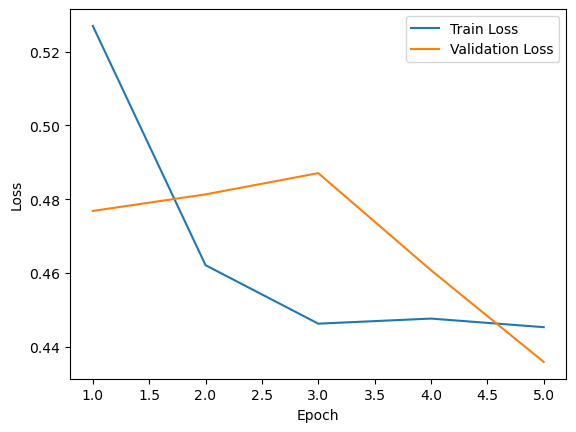

In [43]:
model = UNetWithoutSkipConnections(in_channels=layer_depth, out_channels=1, dropout_prob=0.1)
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
batch_size = 16

best_test_loss = float('inf')
best_model_state = None

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()

    batch_no = 1

    for batch in train_loader:

        print('Epoch',epoch,'Processing Batch No:', batch_no)

        images, labels = batch

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        batch_no = batch_no + 1

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, labels.float())

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model state (lowest test loss)
model.load_state_dict(best_model_state)
torch.save(model, '../models/ink_detection_256_simple_u_net_middle_layer_epoch_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')

In [44]:
test_data = load_dataset(VESUVIUS_DATA_PATH, dataset = 'test')

Fragment: a Loaded: crop_7.png
Fragment: a Loaded: crop_8.png
Fragment: a Loaded: crop_9.png
Fragment: a Loaded: crop_10.png
Fragment: a Loaded: crop_11.png
Fragment: a Loaded: crop_12.png
Fragment: a Loaded: crop_13.png
Fragment: a Loaded: crop_19.png
Fragment: a Loaded: crop_20.png
Fragment: a Loaded: crop_21.png
Fragment: a Loaded: crop_22.png
Fragment: a Loaded: crop_23.png
Fragment: a Loaded: crop_24.png
Fragment: a Loaded: crop_25.png
Fragment: a Loaded: crop_26.png
Fragment: a Loaded: crop_27.png
Fragment: a Loaded: crop_32.png
Fragment: a Loaded: crop_33.png
Fragment: a Loaded: crop_34.png
Fragment: a Loaded: crop_35.png
Fragment: a Loaded: crop_36.png
Fragment: a Loaded: crop_37.png
Fragment: a Loaded: crop_38.png
Fragment: a Loaded: crop_39.png
Fragment: a Loaded: crop_40.png
Fragment: a Loaded: crop_41.png
Fragment: a Loaded: crop_45.png
Fragment: a Loaded: crop_46.png
Fragment: a Loaded: crop_47.png
Fragment: a Loaded: crop_48.png
Fragment: a Loaded: crop_49.png
Fragment: a

In [45]:
test_dataset = test_data

In [46]:
for i in range(len(test_dataset)):
    test_dataset[i][0] = test_dataset[i][0][:,:,:,:,0]

In [47]:
for i in range(len(test_dataset)):
    test_dataset[i][0] = test_dataset[i][0].reshape(test_dataset[i][0].shape[0],test_dataset[i][0].shape[1],crop_size,crop_size)

In [48]:
test_dataset[0][0].shape

(49, 65, 256, 256)

In [839]:
# volume_test_data = np.concatenate([arr[0] for arr in test_dataset], axis=0)
# volume_test_data = volume_test_data[:,:layer_depth,:,:,]

In [49]:
frag_test_data=test_dataset[0][0] #[fragment][volume/label]
frag_test_data=frag_test_data[:,18:50,:,:,]
frag_test_data.shape

(49, 32, 256, 256)

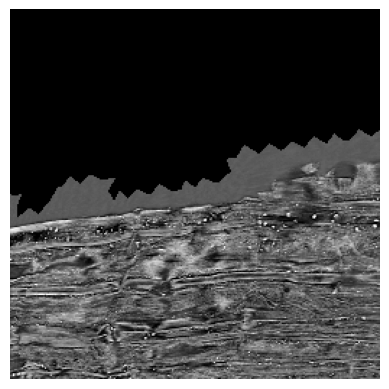

In [50]:
# Display the grayscale image
plt.imshow(frag_test_data[0][0], cmap="gray") # [fragment][train][layer][image]
plt.axis("off")
plt.show()

In [51]:
test_tensor = torch.from_numpy(frag_test_data)
test_tensor = test_tensor.to(torch.float32)

In [52]:
test_loader = DataLoader(test_tensor, batch_size=1)

In [53]:
model = torch.load('../models/ink_detection_256_simple_u_net_middle_layer_epoch_5_batch_16.pt')

model.eval()  # Set the model to evaluation mode

results_test = []

with torch.no_grad():
    for batch in test_loader:
        # Move the batch to the GPU if available
        batch = batch.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test.append(outputs)

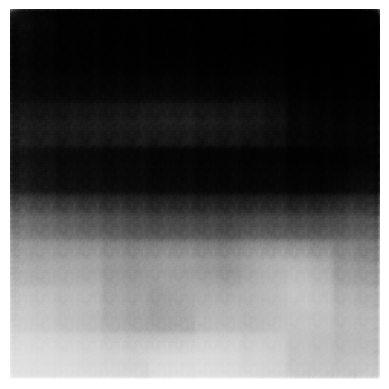

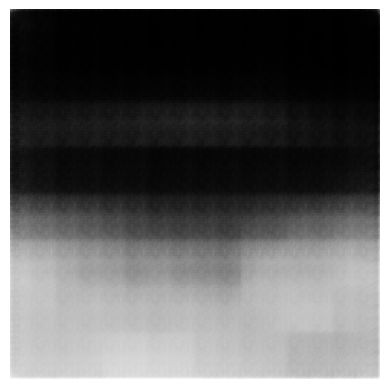

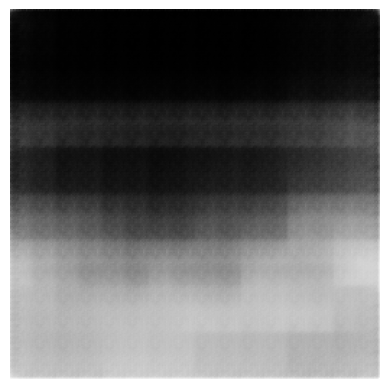

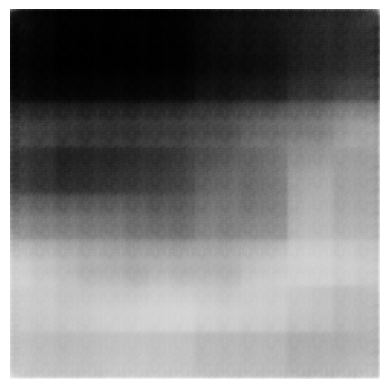

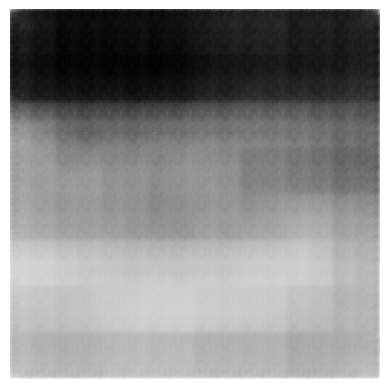

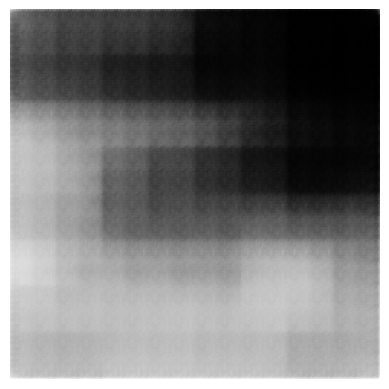

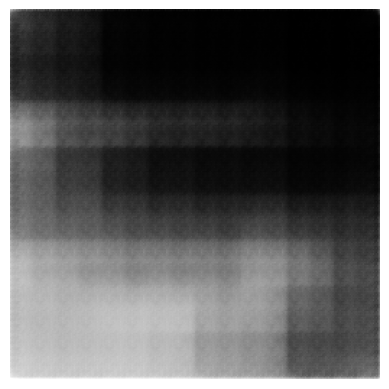

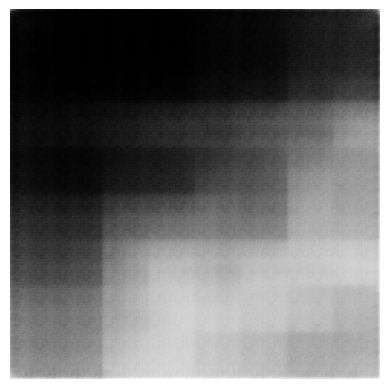

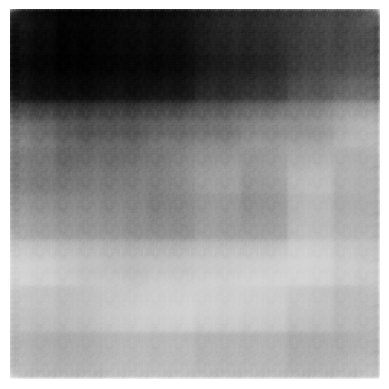

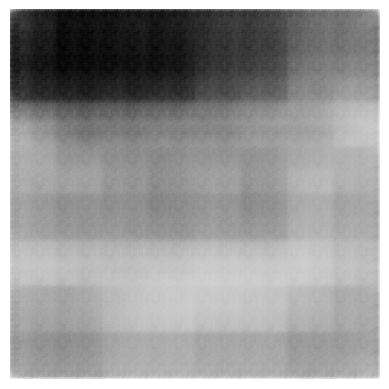

In [59]:
outputs_np = []
for result in results_test[:10]:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()

In [646]:
# #Evaluate results for validation set
# frag_val_data=X_val
# frag_val_data=frag_val_data[:,:layer_depth,:,:,]
# frag_val_data.shape

In [647]:
# # Display the grayscale image
# plt.imshow(frag_val_data[0][0], cmap="gray") # [fragment][train][layer][image]
# plt.axis("off")
# plt.show()

In [648]:
# X_val.shape

In [649]:
# val_tensor = torch.from_numpy(frag_val_data)
# val_dataset_tensor = val_tensor.to(torch.float32)

In [650]:
# val_loader = DataLoader(val_dataset_tensor, batch_size=1)

In [651]:
# results_val = []
#
# with torch.no_grad():
#     for batch in val_loader:
#         # Move the batch to the GPU if available
#         batch = batch.to(device) if torch.cuda.is_available() else batch
#
#         # Perform inference
#         outputs = model(batch)
#         results_val.append(outputs)

In [652]:
# outputs_np = []
# for result in results_val[:5]:
#     # Convert the PyTorch tensor to a NumPy array
#     outputs_np.append(result.cpu().numpy())
#
# # Iterate over the outputs
# for i in range(len(outputs_np)):
#     output = outputs_np[i][0][0]
#
#     # Display the output as an image
#     plt.imshow(output, cmap='gray')  # Assuming grayscale images
#     plt.axis('off')
#     plt.show()

In [55]:
FRAGMENT_A_MASKED_CROPS_PATH = '../../Datasets/vesuvius-challenge-ink-detection/cropped_test_256/a/masked_crops.txt'
FRAGMENT_A_HEIGHT = 190
FRAGMENT_A_WIDTH = 443

In [56]:
#Stiching test results

crop_positions = get_crop_numer_list(file_name= FRAGMENT_A_MASKED_CROPS_PATH)

In [57]:
stitched_image = stitch_crops(FRAGMENT_A_HEIGHT,FRAGMENT_A_WIDTH,results_test,crop_positions)

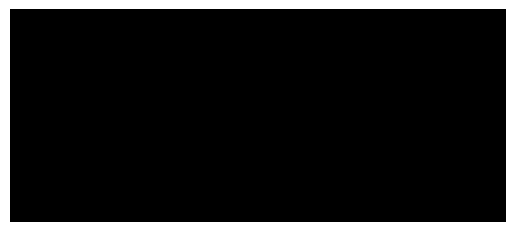

In [58]:
# Display the output as an image
plt.imshow(stitched_image, cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

In [850]:
#Infer results for  fragment b

frag_test_data_b=test_dataset[1][0] #[fragment][volume/label]
frag_test_data_b=frag_test_data_b[:,:layer_depth,:,:,]
frag_test_data_b.shape

(772, 32, 70, 70)

In [851]:
test_tensor_b = torch.from_numpy(frag_test_data_b)
test_tensor_b = test_tensor_b.to(torch.float32)

In [852]:
test_loader_b = DataLoader(test_tensor_b, batch_size=1)

In [853]:
results_test_b = []

with torch.no_grad():
    for batch in test_loader_b:
        # Move the batch to the GPU if available
        batch = batch.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test_b.append(outputs)

In [854]:
FRAGMENT_MASKED_CROPS_PATH = '../../Datasets/vesuvius-challenge-ink-detection/cropped_test/b/masked_crops.txt'
FRAGMENT_HEIGHT = 381
FRAGMENT_WIDTH = 443

In [855]:
crop_positions = get_crop_numer_list(file_name= FRAGMENT_MASKED_CROPS_PATH)

In [856]:
stitched_image = stitch_crops(FRAGMENT_HEIGHT,FRAGMENT_WIDTH,results_test_b,crop_positions)

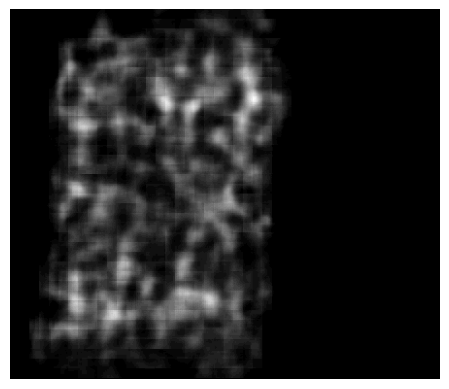

In [857]:
# Display the output as an image
plt.imshow(stitched_image, cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

In [858]:
#Using pretrained ALPUB UNet to train a model

model = UNetWithoutSkipConnections(in_channels=layer_depth, out_channels=1)  # Create an instance of the model

# Load the saved model weights
saved_model_path = '../models/alpub_simple_u_net.pt'

# Load the state dictionary of the saved model
saved_model_dict = torch.load(saved_model_path).state_dict()
model_dict = model.state_dict()

In [859]:
saved_model_dict.keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias'])

In [860]:
model_dict.keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias'])

In [861]:
model_dict['decoder.0.weight'] = saved_model_dict['decoder.0.weight']
model_dict['decoder.0.bias'] = saved_model_dict['decoder.0.bias']
model_dict['decoder.2.weight'] = saved_model_dict['decoder.2.weight']
model_dict['decoder.2.bias'] = saved_model_dict['decoder.2.bias']
model_dict['decoder.4.weight'] = saved_model_dict['decoder.4.weight']
model_dict['decoder.4.bias'] = saved_model_dict['decoder.4.bias']
model_dict['decoder.6.weight'] = saved_model_dict['decoder.6.weight']
model_dict['decoder.6.bias'] = saved_model_dict['decoder.6.bias']

In [862]:
model.load_state_dict(model_dict)

<All keys matched successfully>

Epoch 0 Processing Batch No: 1
Epoch 0 Processing Batch No: 2
Epoch 0 Processing Batch No: 3
Epoch 0 Processing Batch No: 4
Epoch 0 Processing Batch No: 5
Epoch 0 Processing Batch No: 6
Epoch 0 Processing Batch No: 7
Epoch 0 Processing Batch No: 8
Epoch 0 Processing Batch No: 9
Epoch 0 Processing Batch No: 10
Epoch 0 Processing Batch No: 11
Epoch 0 Processing Batch No: 12
Epoch 0 Processing Batch No: 13
Epoch 0 Processing Batch No: 14
Epoch 0 Processing Batch No: 15
Epoch 0 Processing Batch No: 16
Epoch 0 Processing Batch No: 17
Epoch 0 Processing Batch No: 18
Epoch 0 Processing Batch No: 19
Epoch 0 Processing Batch No: 20
Epoch 0 Processing Batch No: 21
Epoch 0 Processing Batch No: 22
Epoch 0 Processing Batch No: 23
Epoch 0 Processing Batch No: 24
Epoch 0 Processing Batch No: 25
Epoch 0 Processing Batch No: 26
Epoch 0 Processing Batch No: 27
Epoch 0 Processing Batch No: 28
Epoch 0 Processing Batch No: 29
Epoch 0 Processing Batch No: 30
Epoch 0 Processing Batch No: 31
Epoch 0 Processin

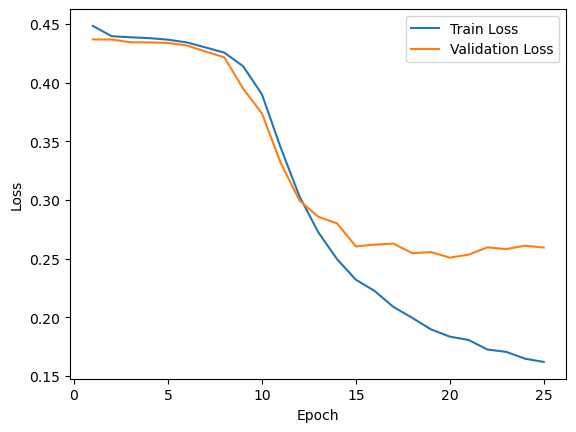

In [863]:
model = model.to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
batch_size = 64

best_test_loss = float('inf')
best_model_state = None

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()

    batch_no = 1

    for batch in train_loader:

        print('Epoch',epoch,'Processing Batch No:', batch_no)

        images, labels = batch

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        batch_no = batch_no + 1

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, labels.float())

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model state (lowest test loss)
model.load_state_dict(best_model_state)
torch.save(model, '../models/ink_detection_simple_u_net_with_alpub_pretrained_epoch_'+str(num_epochs)+'_batch_'+str(batch_size)+'.pt')

In [864]:
model = torch.load('../models/ink_detection_simple_u_net_middle_layer_with_alpub_pretrained_epoch_25_batch_64.pt')

model.eval()  # Set the model to evaluation mode

results_test_a = []

with torch.no_grad():
    for batch in test_loader:
        # Move the batch to the GPU if available
        batch = batch.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test_a.append(outputs)

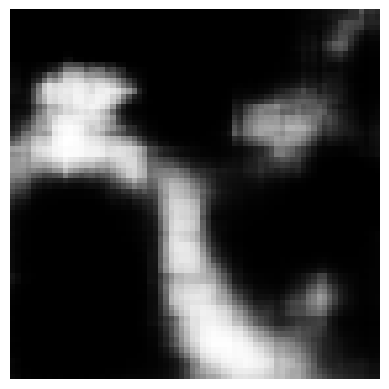

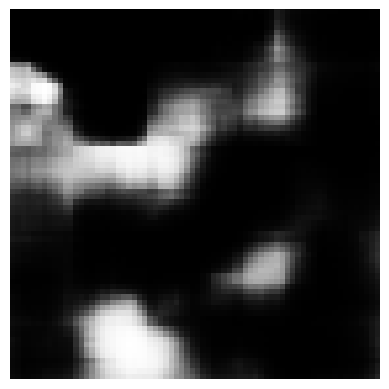

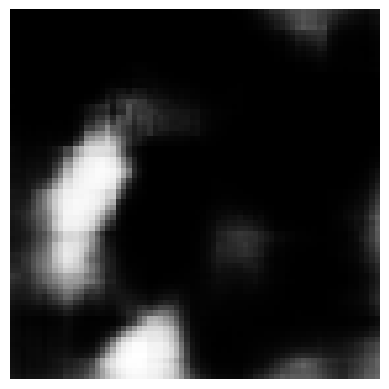

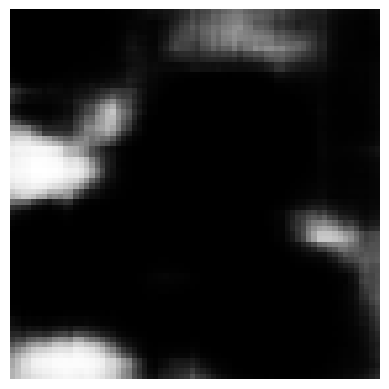

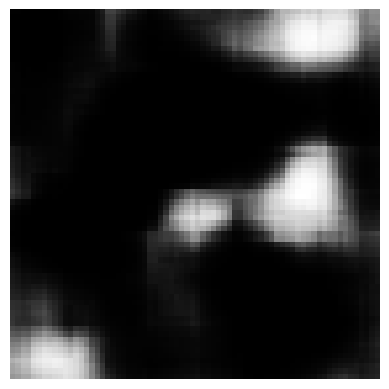

In [865]:
outputs_np = []
for result in results_test_a[:5]:
    # Convert the PyTorch tensor to a NumPy array
    outputs_np.append(result.cpu().numpy())

# Iterate over the outputs
for i in range(len(outputs_np)):
    output = outputs_np[i][0][0]

    # Display the output as an image
    plt.imshow(output, cmap='gray')  # Assuming grayscale images
    plt.axis('off')
    plt.show()

In [866]:
#Stiching test results

crop_positions = get_crop_numer_list(file_name= FRAGMENT_A_MASKED_CROPS_PATH)

In [867]:
stitched_image = stitch_crops(FRAGMENT_A_HEIGHT,FRAGMENT_A_WIDTH,results_test_a,crop_positions)

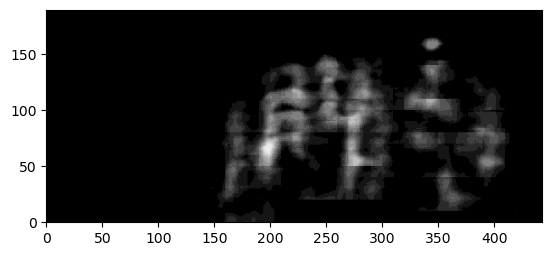

In [868]:
# Display the output as an image
plt.imshow(stitched_image, cmap='gray',extent=[0, stitched_image.shape[1], 0, stitched_image.shape[0]])  # Assuming grayscale images
plt.axis('on')
plt.show()

In [869]:
from ink_detection_utils import get_crop_position

get_crop_position(FRAGMENT_A_HEIGHT, FRAGMENT_WIDTH, 100)

(240, 70)

In [872]:
results_test_b = []

with torch.no_grad():
    for batch in test_loader_b:
        # Move the batch to the GPU if available
        batch = batch.to(device) if torch.cuda.is_available() else batch

        # Perform inference
        outputs = model(batch)
        results_test_b.append(outputs)

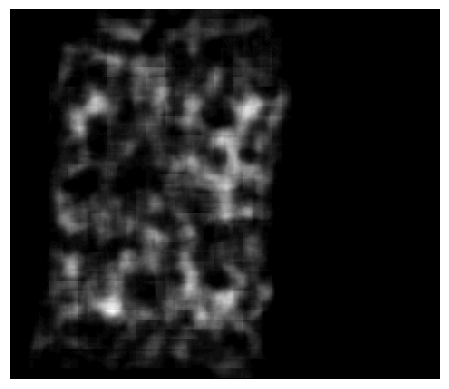

In [873]:
crop_positions = get_crop_numer_list(file_name=FRAGMENT_MASKED_CROPS_PATH)
stitched_image = stitch_crops(FRAGMENT_HEIGHT, FRAGMENT_WIDTH, results_test_b, crop_positions)
# Display the output as an image
plt.imshow(stitched_image, cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()